In [13]:
using Revise
using Printf
using LinearAlgebra
using PyPlot
using FFTW
using MultiModeNoise

[ Info: Precompiling MultiModeNoise [b336628f-8386-4303-a33d-f2bdce4c2a6e]


# Setup

In [14]:
λ0 = 1550e-9 # m
M = 3
P = 1e4 # W
δF_in = 999;

In [15]:
sim = MultiModeNoise.get_cw_sim_params(λ0, M, P, δF_in);

In [16]:
L_fiber = 5 # m
radius = 62.5/2 # micron
core_NA = 0.275
alpha = 2.08
nx = 200
fiber_fname = @sprintf("../fibers/CWFiber_GRIN_r=%.2f_M=%d_λ0=%.2fum_nx=%d.npz", radius, M, 1e6*λ0, nx)

"../fibers/CWFiber_GRIN_r=31.25_M=3_λ0=1.55um_nx=200.npz"

In [17]:
fiber = MultiModeNoise.get_cw_fiber_params(L_fiber, radius, core_NA, alpha, nx, sim, fiber_fname);

Load fiber params


In [18]:
fiber["zsave"] = LinRange(0, L_fiber, 101);

In [19]:
u0 = √P*normalize([0.4, 0.1, 0.0]) .+ 0im
println(abs2.(u0)/P)

[0.9411764705882353, 0.058823529411764705, 0.0]


# Solve for field and Bogolubiov coefficients

In [20]:
sol = MultiModeNoise.solve_cw_mmf(u0, fiber, sim);

In [21]:
uf = sol["uz"][end,:]
μf = sol["μz"][end,:,:]
νf = sol["νz"][end,:,:];

In [22]:
n, var_n = MultiModeNoise.compute_cw_spatial_n_var_n(u0, uf, μf, νf, δF_in, fiber["phi"], P);

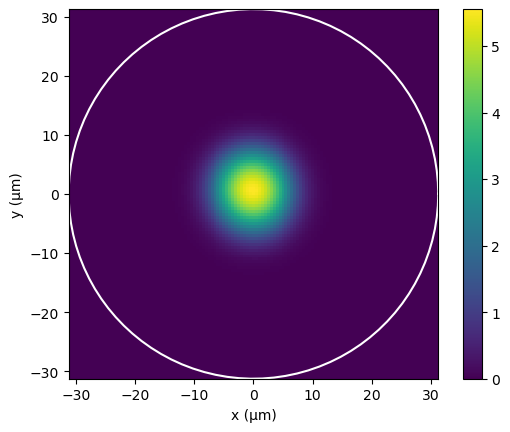

PyObject Text(24.000000000000007, 0.5, 'y (μm)')

In [23]:
MultiModeNoise.plot_fiber(fiber["x"], MultiModeNoise.lin_to_dB.(reshape(var_n ./ n, (nx,nx))), radius, radius)

In [24]:
nf, var_n = MultiModeNoise.compute_cw_modal_n_var_n(u0, uf, μf, νf, δF_in, P)
MultiModeNoise.lin_to_dB.( var_n ./ nf)

3-element Vector{Float64}:
 29.738395265744195
 17.74904226069055
  1.9693246904226782

# Minimize Fano factor in a particular mode

In [40]:
function calc_output_reim(u0_reim, fiber, sim)
    fiber["zsave"] = [0, fiber["L"]]
    M = sim["M"]
    u0 = u0_reim[1:M] + 1im*u0_reim[M+1:2*M]
    sol = MultiModeNoise.solve_cw_mmf(u0, fiber, sim)

    uf = sol["uz"][end,:]
    μf = sol["μz"][end,:,:]
    νf = sol["νz"][end,:,:]

    return uf, μf, νf
end

calc_output_reim (generic function with 1 method)

In [41]:
function calc_F∇F_dB!(Objective, Grad, x, p)
    opt_mode, fiber, sim = p
    P = sim["P"]
    
    u0_reim = √P*normalize(x)

    ∂a∂x = sqrt(P)/norm(x)*(diagm(ones(length(x))) - x*x'/norm(x)^2)

    uf_reim, ∇n = MultiModeNoise.solve_∇n_modes_cw_mmf_adjoint_reim(u0_reim, p; return_u=true)
    n = uf_reim[1:M][opt_mode]^2 + uf_reim[M+1:2*M][opt_mode]^2
    var_n = ∇n' * ∇n
    F = var_n / n

    if Grad !== nothing
        ∇_var_n = ForwardDiff.derivative(α -> MultiModeNoise.solve_∇n_modes_cw_mmf_adjoint_reim(u0_reim + 2*α*∇n, p; return_u=false), 0)
        ∇F = ∇_var_n/n .- 2*var_n/n^2*∇n
        ∇F = ∂a∂x' * ∇F
        Grad .= 10/log(10) * ∇F / F
    end
    if Objective !== nothing
        return MultiModeNoise.lin_to_dB(F)
    end
end

calc_F∇F_dB! (generic function with 1 method)

In [42]:
function callback_dB(state)
    if mod(state.iteration, 1) == 0
        println(@sprintf("Iteration: %d: F = %.6f dB, |g(x)| = %.8f", state.iteration, state.value, state.g_norm)); flush(stdout)
    end
    return false  # Return `true` to stop optimization early
end

callback_dB (generic function with 1 method)

In [43]:
using OptimizationOptimJL
using ForwardDiff
using Random

In [44]:
x0 = 20*rand(MersenneTwister(2), 2*M) .- 10
u0_x0_reim = √P*normalize(x0)
u0_x0 = u0_x0_reim[1:M] + 1im*u0_x0_reim[M+1:2*M];

In [45]:
uf_x0, μf_x0, νf_x0 = calc_output_reim(u0_x0_reim, fiber, sim)
nf_x0, var_n_x0 = MultiModeNoise.compute_cw_modal_n_var_n(u0_x0, uf_x0, μf_x0, νf_x0, 0, P)
MultiModeNoise.lin_to_dB.(var_n_x0 ./ nf_x0)

3-element Vector{Float64}:
  0.0016106671811375998
 14.904249440989044
  3.048105738006405

In [46]:
opt_mode = 2;
p_opt = (opt_mode, fiber, sim);

In [47]:
res = optimize(Optim.only_fg!((Objective, Grad, x) -> calc_F∇F_dB!(Objective, Grad, x, p_opt)), x0, LBFGS(), 
    Optim.Options(f_abstol=1e-5, iterations=10, callback=callback_dB))

Iteration: 0: F = 14.904406 dB, |g(x)| = 1.61077778
Iteration: 1: F = 0.143092 dB, |g(x)| = 0.89651895
Iteration: 2: F = 0.077395 dB, |g(x)| = 0.75190010
Iteration: 3: F = -0.083798 dB, |g(x)| = 0.63713552
Iteration: 4: F = -0.307195 dB, |g(x)| = 0.43333045
Iteration: 5: F = -0.772974 dB, |g(x)| = 1.13786591
Iteration: 6: F = -2.341655 dB, |g(x)| = 1.92011419
Iteration: 7: F = -4.008966 dB, |g(x)| = 1.04473408
Iteration: 8: F = -4.216734 dB, |g(x)| = 0.18461097
Iteration: 9: F = -4.464462 dB, |g(x)| = 0.92326677
Iteration: 10: F = -5.260327 dB, |g(x)| = 0.42833602


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     -5.260327e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 7.73e+00 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.87e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.96e-01 ≰ 1.0e-05
    |f(x) - f(x')|/|f(x')| = 1.51e-01 ≰ 0.0e+00
    |g(x)|                 = 4.28e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit Inf)
    Iterations:    10
    f(x) calls:    33
    ∇f(x) calls:   33


In [48]:
u0_x_reim = √P*normalize(res.minimizer)
u0_x = u0_x_reim[1:M] + 1im*u0_x_reim[M+1:2*M]
uf_x, μf_x, νf_x = calc_output_reim(u0_x_reim, fiber, sim)
nf_x, var_n_x = MultiModeNoise.compute_cw_modal_n_var_n(u0_x, uf_x, μf_x, νf_x, 0, P);

In [49]:
MultiModeNoise.lin_to_dB.(var_n_x0 ./ nf_x0)

3-element Vector{Float64}:
  0.0016106671811375998
 14.904249440989044
  3.048105738006405

In [50]:
MultiModeNoise.lin_to_dB.(var_n_x ./ nf_x)

3-element Vector{Float64}:
  0.0034602335824299103
 -5.262350497575906
  2.5293942434749916

In [51]:
nf_x ./ nf_x0

3-element Vector{Float64}:
  0.5902767405578321
 12.573623071418975
  1.1517922595412537

# Minimize Fano factor at a particular pixel / combination of pixels

In [52]:
function calc_F∇F_dB!(Objective, Grad, x, p)
    pixel_indices, fiber, sim = p
    M = sim["M"]
    P = sim["P"]
    δF_in = sim["dF_in"]
    ϕ = fiber["phi"]
    ϕ_pixels = ϕ[pixel_indices,:]
    
    A = [[diagm(ones(M)) 1im*diagm(ones(M))]; [-1im*diagm(ones(M)) diagm(ones(M))]] / sqrt(P)

    u0_reim_norm = normalize(x)
    u0_reim = √P*u0_reim_norm
    u0 = u0_reim[1:M] + 1im*u0_reim[M+1:2*M]
    Uk = u0/√P
    Ũk = [Uk; -1im*Uk]

    ∂a∂x = sqrt(P)/norm(x)*(diagm(ones(length(x))) - x*x'/norm(x)^2)

    uf_reim, ∇n = MultiModeNoise.solve_∇n_pixels_cw_mmf_adjoint_reim(u0_reim, p; return_u=true)
    uf = uf_reim[1:M] + 1im*uf_reim[M+1:2*M]
    αi = ϕ_pixels * uf
    n = real(αi' * αi)
    
    no_derivative_term = real( αi' * αi - sum(abs2.(ϕ_pixels' * αi)) )
    shot_noise = ∇n' * ∇n / 4
    excess_noise = δF_in * abs2.(∇n' * A * u0_reim) / 4
    var_n = no_derivative_term + shot_noise + excess_noise
    
    F = var_n / n

    if Grad !== nothing
        B = ϕ_pixels' * ϕ_pixels * ϕ_pixels' * ϕ_pixels
        ∇g = 0.5*∇n + 0.5*δF_in*real.( (∇n' * conj.(Ũk)) * Ũk )
        ∇_var_n = ForwardDiff.derivative(α -> MultiModeNoise.solve_∇n_pixels_cw_mmf_adjoint_reim(u0_reim + α*∇g, p; return_u=false), 0)
        ∇_var_n += 0.5*δF_in*real.((∇n' * A * u0_reim) * A * ∇n)

        uf, μf, νf = calc_output_reim(u0_reim, fiber, sim)
        ∂udBu∂u = νf' * B * uf + transpose(uf' * B * μf)
        ∇_no_derivative_term = ∇n - real.([∂udBu∂u + conj.(∂udBu∂u); 1im*(∂udBu∂u - conj.(∂udBu∂u))])
        ∇_var_n += ∇_no_derivative_term 
        
        ∇F = ∇_var_n/n - var_n/n^2*∇n
        ∇F = ∂a∂x' * ∇F
        Grad .= 10/log(10) * ∇F / F
    end
    if Objective !== nothing
        return MultiModeNoise.lin_to_dB(F)
    end
end

calc_F∇F_dB! (generic function with 1 method)

In [53]:
x = fiber["x"]
XX, YY = MultiModeNoise.meshgrid(x, x);

In [54]:
superpixel_size = 3;

In [55]:
idx = rand(MersenneTwister(1), (1:nx^2)[vec(XX).^2 + vec(YY).^2 .<= 10^2])
pixels = MultiModeNoise.get_center_square_pixels(nx, superpixel_size, [argmin((x .- vec(XX)[idx]).^2), argmin((x .- vec(YY)[idx]).^2)])
pixel_indices = MultiModeNoise.get_center_square_ids_flat(XX, YY, pixels);

In [56]:
p_opt = (pixel_indices, fiber, sim);

In [57]:
x0 = 20*rand(MersenneTwister(3), 2*M) .- 10
u0_x0_reim = √P*normalize(x0)
u0_x0 = u0_x0_reim[1:M] + 1im*u0_x0_reim[M+1:2*M];

In [58]:
uf_x0, μf_x0, νf_x0 = calc_output_reim(u0_x0_reim, fiber, sim);

In [59]:
n_x0, var_n_x0 = MultiModeNoise.compute_cw_superpixel_n_var_n(u0_x0, uf_x0, μf_x0, νf_x0, pixel_indices, δF_in, fiber["phi"], P);

In [60]:
MultiModeNoise.lin_to_dB(var_n_x0 / n_x0)

27.030640254082638

In [61]:
res = optimize(Optim.only_fg!((Objective, Grad, x) -> calc_F∇F_dB!(Objective, Grad, x, p_opt)), x0, LBFGS(), 
        Optim.Options(f_abstol=1e-5, iterations=10, callback=callback_dB))

Iteration: 0: F = 27.034914 dB, |g(x)| = 0.84786433
Iteration: 1: F = 9.823251 dB, |g(x)| = 51.52209603
Iteration: 2: F = 4.221600 dB, |g(x)| = 96.48633494
Iteration: 3: F = 0.866915 dB, |g(x)| = 61.41524099
Iteration: 4: F = 0.292077 dB, |g(x)| = 3.10346164
Iteration: 5: F = 0.290807 dB, |g(x)| = 0.42392454
Iteration: 6: F = 0.290542 dB, |g(x)| = 0.91008008
Iteration: 7: F = 0.288931 dB, |g(x)| = 5.16796048
Iteration: 8: F = 0.213923 dB, |g(x)| = 16.84180249
Iteration: 9: F = 0.072442 dB, |g(x)| = 14.34517396
Iteration: 10: F = 0.060862 dB, |g(x)| = 1.01865146


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     6.086175e-02

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 7.19e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.22e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.16e-02 ≰ 1.0e-05
    |f(x) - f(x')|/|f(x')| = 1.90e-01 ≰ 0.0e+00
    |g(x)|                 = 1.02e+00 ≰ 1.0e-08

 * Work counters
    Seconds run:   12  (vs limit Inf)
    Iterations:    10
    f(x) calls:    35
    ∇f(x) calls:   35


In [84]:
u0_x_reim = √P*normalize(res.minimizer)
u0_x = u0_x_reim[1:M] + 1im*u0_x_reim[M+1:2*M]
uf_x, μf_x, νf_x = calc_output_reim(u0_x_reim, fiber, sim);
n_x, var_n_x = MultiModeNoise.compute_cw_superpixel_n_var_n(u0_x, uf_x, μf_x, νf_x, pixel_indices, δF_in, fiber["phi"], P);

In [85]:
MultiModeNoise.lin_to_dB(var_n_x / n_x)

0.06129335698471683

In [86]:
n_x0, var_n_x0 = MultiModeNoise.compute_cw_spatial_n_var_n(u0_x0, uf_x0, μf_x0, νf_x0, δF_in, fiber["phi"], P);
n_x, var_n_x = MultiModeNoise.compute_cw_spatial_n_var_n(u0_x, uf_x, μf_x, νf_x, δF_in, fiber["phi"], P);

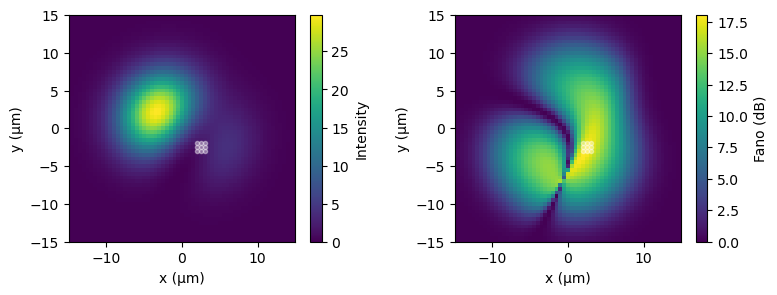

In [87]:
figure(figsize=(8,3))
subplot(121)
MultiModeNoise.plot_fiber(fiber["x"], reshape(n_x0, (nx,nx)), 15, radius; cbarlabel="Intensity")
plot(vec(XX)[pixel_indices], vec(YY)[pixel_indices], "w.", alpha=0.4)
subplot(122)
MultiModeNoise.plot_fiber(fiber["x"], MultiModeNoise.lin_to_dB.(reshape(var_n_x0 ./ n_x0, (nx,nx))), 15, radius; cbarlabel="Fano (dB)")
plot(vec(XX)[pixel_indices], vec(YY)[pixel_indices], "w.", alpha=0.4)
tight_layout()

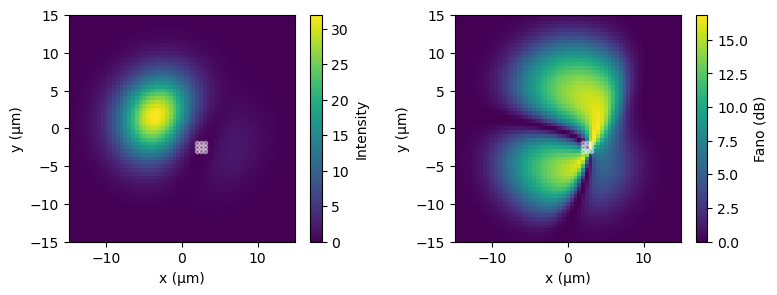

In [88]:
figure(figsize=(8,3))
subplot(121)
MultiModeNoise.plot_fiber(fiber["x"], reshape(n_x, (nx,nx)), 15, radius; cbarlabel="Intensity")
plot(vec(XX)[pixel_indices], vec(YY)[pixel_indices], "w.", alpha=0.4)
subplot(122)
MultiModeNoise.plot_fiber(fiber["x"], MultiModeNoise.lin_to_dB.(reshape(var_n_x ./ n_x, (nx,nx))), 15, radius; cbarlabel="Fano (dB)")
plot(vec(XX)[pixel_indices], vec(YY)[pixel_indices], "w.", alpha=0.4)
tight_layout()

In [89]:
function compute_var_n_LA(n_out, P, F_in)
    l = n_out / P
    return l^2 * P * F_in + l * (1 - l) * P
end

function compute_var_n_rel_LA(n, var_n, noise_floor, P, F_in)
    var_n_LA = compute_var_n_LA(n, P, F_in)
    return (noise_floor + var_n) / (noise_floor + var_n_LA)
end

compute_var_n_rel_LA (generic function with 1 method)

In [90]:
using PyCall
@pyimport matplotlib.colors as mplcolors

In [91]:
noise_floor = 0.1;

In [92]:
var_n_x0_rel_LA = compute_var_n_rel_LA.(n_x0, var_n_x0, noise_floor, P, 1 + δF_in)[:,1];
var_n_x_rel_LA = compute_var_n_rel_LA.(n_x, var_n_x, noise_floor, P, 1 + δF_in)[:,1];

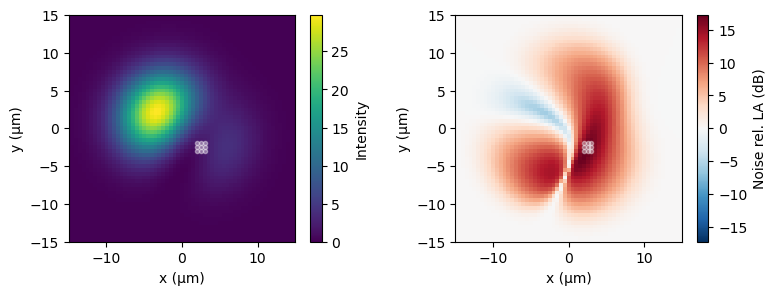

In [93]:
figure(figsize=(8,3))
subplot(121)
MultiModeNoise.plot_fiber(fiber["x"], reshape(n_x0, (nx,nx)), 15, radius; cbarlabel="Intensity")
plot(vec(XX)[pixel_indices], vec(YY)[pixel_indices], "w.", alpha=0.4)
subplot(122)
MultiModeNoise.plot_fiber(fiber["x"], MultiModeNoise.lin_to_dB.(reshape(var_n_x0_rel_LA, (nx,nx))), 15, radius; cmap="RdBu_r", 
    cbarlabel="Noise rel. LA (dB)", norm=mplcolors.CenteredNorm(vcenter=0))
plot(vec(XX)[pixel_indices], vec(YY)[pixel_indices], "w.", alpha=0.4)
tight_layout()

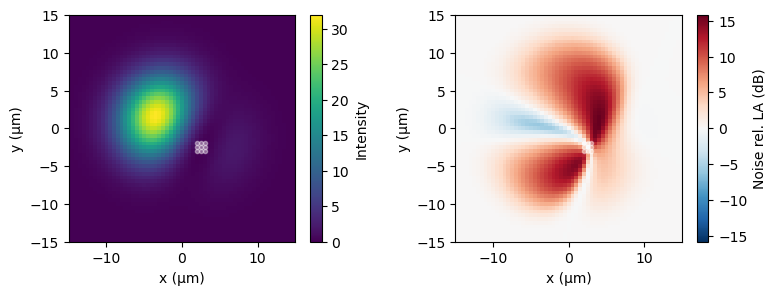

In [94]:
figure(figsize=(8,3))
subplot(121)
MultiModeNoise.plot_fiber(fiber["x"], reshape(n_x, (nx,nx)), 15, radius; cbarlabel="Intensity")
plot(vec(XX)[pixel_indices], vec(YY)[pixel_indices], "w.", alpha=0.4)
subplot(122)
MultiModeNoise.plot_fiber(fiber["x"], MultiModeNoise.lin_to_dB.(reshape(var_n_x_rel_LA, (nx,nx))), 15, radius; cmap="RdBu_r", 
    cbarlabel="Noise rel. LA (dB)", norm=mplcolors.CenteredNorm(vcenter=0))
plot(vec(XX)[pixel_indices], vec(YY)[pixel_indices], "w.", alpha=0.4)
tight_layout()

# Compute the intensity noise of randomly SLM patterns and combinations of output pixels

In [95]:
apt_radius = 20
apt_inds = (1:nx^2)[vec(XX.^2 + YY.^2 .<= apt_radius.^2)]
n_pixels = 10
shift = 6
k_grid_width = 5
k_grid_height = 5
σ = 3.68; #micron

In [96]:
fourier_coefs = randn(MersenneTwister(0), k_grid_height*k_grid_width);

In [97]:
beam = MultiModeNoise.gauss(XX, YY, σ);

In [98]:
u0 = MultiModeNoise.fourier_coefs_to_u0(fourier_coefs, fiber, sim, k_grid_width, k_grid_height, beam; fourier_zoom=4, shift=shift);

In [99]:
fiber["zsave"] = [0, L_fiber];

In [100]:
sol = MultiModeNoise.solve_cw_mmf(u0, fiber, sim)
uf = sol["uz"][end,:]
μf = sol["μz"][end,:,:]
νf = sol["νz"][end,:,:];

In [101]:
pixel_collection_indices = shuffle(MersenneTwister(0), apt_inds)[1:n_pixels];

In [102]:
n_xy, var_n_xy = MultiModeNoise.compute_cw_spatial_n_var_n(u0, uf, μf, νf, δF_in, fiber["phi"], P);

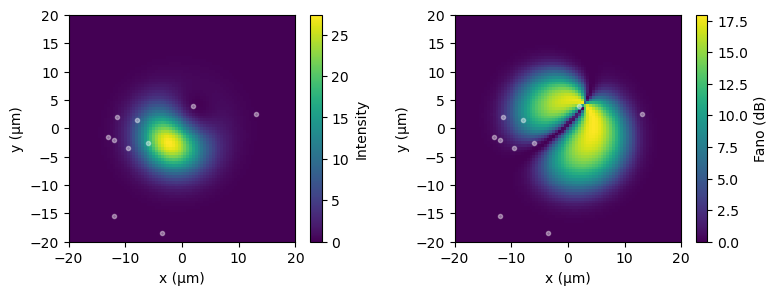

In [103]:
figure(figsize=(8,3))
subplot(121)
MultiModeNoise.plot_fiber(fiber["x"], reshape(n_xy, (nx,nx)), apt_radius, radius; cbarlabel="Intensity")
plot(vec(XX)[pixel_collection_indices], vec(YY)[pixel_collection_indices], "w.", alpha=0.4)
subplot(122)
MultiModeNoise.plot_fiber(fiber["x"], MultiModeNoise.lin_to_dB.(reshape(var_n_xy ./ n_xy, (nx,nx))), apt_radius, radius; 
    cbarlabel="Fano (dB)")
plot(vec(XX)[pixel_collection_indices], vec(YY)[pixel_collection_indices], "w.", alpha=0.4)
tight_layout()

In [104]:
n, var_n = MultiModeNoise.compute_cw_superpixel_n_var_n(u0, uf, μf, νf, pixel_collection_indices, δF_in, fiber["phi"], P);

In [105]:
MultiModeNoise.lin_to_dB.(var_n / n)

8.657363306461892